In [1]:
%cd C:\Users\yukir\Documents\GitHub\Sign_Recognition\py

C:\Users\yukir\Documents\GitHub\Sign_Recognition\py


In [2]:
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import TensorBoard
from time import time

In [3]:
from basic_preprocessing import *
from deeplearning_check import *
from machine_learning import *

gpu_check()
set_global_determinism(seed=SEED)

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16881385686747314160
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4498270488870821586
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9883535296
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10359983475297900813
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4355366082632325331
physical_device_desc: "device: XLA_GPU device"
]
tf 2.2.0
keras 2.3.0-tf
set_global_determinism(seed=1337) 이거 꼭 해라
set_global_determinism(seed=1337) 이거 꼭 해라
set_global_determinism(seed=1337) 이거 꼭 해라


In [4]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

#### basic model

In [5]:
set_global_determinism(seed=1337)

In [37]:
train_dir = 'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\Stratified\\train'
test_dir = 'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\For test'
val_dir ='C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\Stratified\\test'

In [38]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [39]:
from keras import Input
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=16, target_size=(200,200), color_mode='rgb')
val_generator = val_datagen.flow_from_directory(val_dir, batch_size=16, target_size=(200, 200), color_mode='rgb')
test_generator = test_datagen.flow_from_directory(test_dir,batch_size=16, target_size=(200, 200), color_mode='rgb')

input_tensor = Input(shape=(200, 200, 3), dtype='float32', name='input')

Found 440 images belonging to 4 classes.
Found 111 images belonging to 4 classes.
Found 185 images belonging to 4 classes.


#### model creating

In [10]:
def create_model():
    optimizer = Adam()
    
    pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
    #include_top FC 레이어 포함유무 결정
    #feature extraction 파라미터들은 이미지넷으로 학습된 값들을 그대로 사용할 것이기 때문에 trainable의 속성을 False
    pre_trained_vgg.trainable = False
    additional_model = tf.keras.Sequential()
    additional_model.add(pre_trained_vgg)
    additional_model.add(Flatten())
    additional_model.add(tf.keras.layers.Dense(4096, activation='relu'))
    additional_model.add(tf.keras.layers.Dense(2048, activation='relu'))
    additional_model.add(tf.keras.layers.Dense(1024, activation='relu'))
    additional_model.add(tf.keras.layers.Dense(4, activation='softmax'))
    

    additional_model.compile(optimizer = optimizer, loss = keras.losses.categorical_crossentropy, metrics=['acc'])

    
    return additional_model

In [11]:
tf.__version__

'2.2.0'

In [12]:
keras.__version__

'2.3.0-tf'

In [13]:
# 모델 실행 옵션 
model = create_model()
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              75501568  
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 4100      
Total params: 100,709,188
Trainable params: 85,994,500
Non-trainable params: 14,714,688
__________________________________

In [15]:
%cd C:\Users\yukir\Documents\Monicas_workspace\Sign detection\VGG

C:\Users\yukir\Documents\Monicas_workspace\Sign detection\VGG


In [16]:
checkpoint_path = "check_point/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [17]:
#모델의 가중치 저장
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
            monitor='loss', 
            mode='min',
            save_best_only=True,
            save_weights_only=True,
            verbose=1)

#새로운 콜백으로 모델 훈련하기
history = model.fit_generator(train_generator, 
            steps_per_epoch=math.ceil(train_generator.n / train_generator.batch_size), 
            epochs=50, 
            validation_data=val_generator, 
            validation_steps=math.ceil(val_generator.n / val_generator.batch_size), 
            callbacks=[checkpoint],
            shuffle=False)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
28/28 [==============================] - ETA: 0s - loss: 4.2767 - acc: 0.6227
Epoch 00001: loss improved from inf to 4.27671, saving model to check_point/cp.ckpt
28/28 [==============================] - 9s 323ms/step - loss: 4.2767 - acc: 0.6227 - val_loss: 0.3731 - val_acc: 0.9009
Epoch 2/50
27/28 [===========================>..] - ETA: 0s - loss: 0.1893 - acc: 0.9398- ETA: 0s - loss: 0.1716 - acc: 0
Epoch 00002: loss improved from 4.27671 to 0.18895, saving model to check_point/cp.ckpt
28/28 [==============================] - 7s 238ms/step - loss: 0.1889 - acc: 0.9386 - val_loss: 0.3278 - val_acc: 0.9279
Epoch 3/50
27/28 [===========================>..] - ETA: 0s - loss: 0.0822 - acc: 0.9769- ETA: 1s - loss: 0. - ETA: 0s - loss: 0.0886 - acc: 0.97
Epoch 00003: loss improved from 0.18895 to 0.08069, saving model to check_point/cp.ckpt
28/28 [==============================] - 7s 242ms/step - loss: 0.

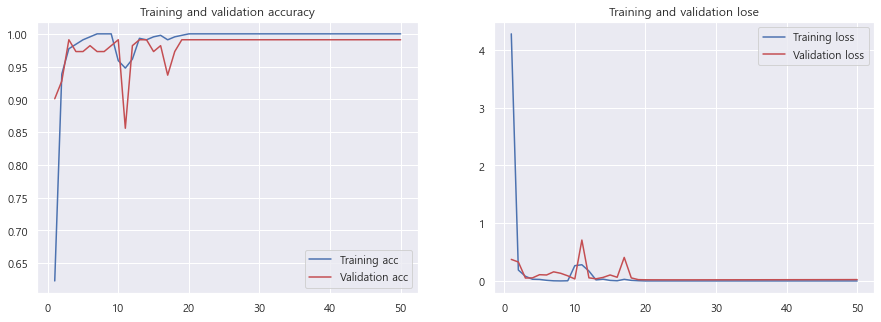

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)
    
    

fig = plt.figure()
fig.set_size_inches(15, 5)

fig.add_subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label ='Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
fig.add_subplot(1, 2, 2) 
plt.plot(epochs, loss, 'b', label = "Training loss")
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and validation lose')
plt.legend()

plt.show()

In [19]:
#맥에서는 !ls
#저장된 checkpoint확인하기
!dir {checkpoint_dir}

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 5848-7E5C

 C:\Users\yukir\Documents\Monicas_workspace\Sign detection\VGG\check_point 디렉터리

2021-09-24  오전 01:36    <DIR>          .
2021-09-24  오전 01:36    <DIR>          ..
2021-09-24  오전 01:36                71 checkpoint
2021-09-24  오전 01:36             7,593 cp.ckpt.data-00000-of-00002
2021-09-24  오전 01:36     1,090,792,776 cp.ckpt.data-00001-of-00002
2021-09-24  오전 01:36             4,030 cp.ckpt.index
               4개 파일       1,090,804,470 바이트
               2개 디렉터리  346,172,858,368 바이트 남음


In [44]:
#가장 마지막에 만들어진 체크포인트 확인
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'check_point\\cp.ckpt'

In [26]:
#모델 평가
model = create_model()
loss, acc = model.evaluate(test_generator)
print("훈련 안 한 모델의 정확도: {:5.2f}%".format(100*acc))

12/12 [==============================] - 1s 52ms/step - loss: 1.5187 - acc: 0.2541
훈련 안 한 모델의 정확도: 25.41%


In [22]:
# 기본 모델 객체를 만듭니다
model = create_model()

# 모델을 평가합니다
loss, acc = model.evaluate(val_generator, verbose=2)
print("훈련되지 않은 모델의 정확도: {:5.2f}%".format(100*acc))

8/8 - 2s - loss: 1.5490 - acc: 0.1626
훈련되지 않은 모델의 정확도: 16.26%


In [ ]:
# 가중치 로드
model.load_weights(latest)

# # 모델 재평가
loss,acc = model.evaluate(val_generator)
print("복원된 모델의 정확도: {:5.2f}%".format(100*acc))

7/7 [==============================] - 0s 47ms/step - loss: 0.0233 - acc: 0.9910
복원된 모델의 정확도: 99.10%


In [40]:
# 가중치 로드
model.load_weights(latest)

# # 모델 재평가
loss,acc = model.evaluate(test_generator)
print("복원된 모델의 정확도: {:5.2f}%".format(100*acc))

12/12 [==============================] - 1s 60ms/step - loss: 1.4562 - acc: 0.8541
복원된 모델의 정확도: 85.41%


In [41]:
past_test_dir = 'C:\\Users\\yukir\\Documents\Monicas_workspace\\Datasets\\For past test'
test_datagen = ImageDataGenerator(rescale=1./255)
past_test_generator = test_datagen.flow_from_directory(past_test_dir,batch_size=16, target_size=(200, 200), color_mode='rgb')

# # 모델 재평가
loss,acc = model.evaluate(past_test_generator)
print("복원된 모델의 정확도: {:5.2f}%".format(100*acc))

Found 97 images belonging to 4 classes.
7/7 [==============================] - 0s 53ms/step - loss: 1.2547 - acc: 0.9175
복원된 모델의 정확도: 91.75%


#### final model save

In [50]:
/pwd

'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Sign detection\\VGG'

In [52]:
model.save('[0924]new_stratified_4class_91.h5')

model_json = model.to_json()
with open("[0924]new_stratified_4class_91.json", "w") as json_file : 
    json_file.write(model_json)

model.save_weights("[0924]new_stratified_4class_91_weight.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
label_dict = get_label_dict(train_generator)
label_dict

{0: 'fragile', 1: 'handle', 2: 'up', 3: 'wet'}

### Test

#### test set

In [31]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3])

Confusion Matrix
[[21  9 15 12]
 [ 4  5  4  7]
 [19  6 14 18]
 [18  6 16 11]]
              precision    recall  f1-score   support

     fragile       0.34      0.37      0.35        57
      handle       0.19      0.25      0.22        20
          up       0.29      0.25      0.26        57
         wet       0.23      0.22      0.22        51

    accuracy                           0.28       185
   macro avg       0.26      0.27      0.26       185
weighted avg       0.28      0.28      0.27       185



<Figure size 432x432 with 0 Axes>

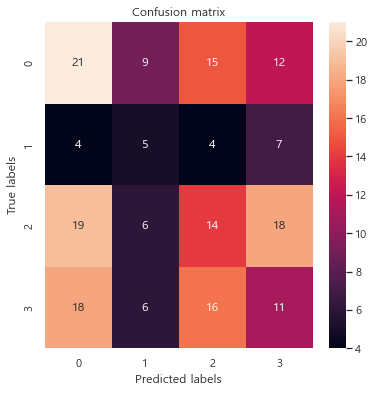

In [34]:
#confusion matrix
from sklearn.metrics import confusion_matrix

# 1.Predict classes
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)


predictions = model.predict_generator(test_generator, steps=test_steps_per_epoch)
# print(predictions)
# # Get most likely class axis=1(열로 가장 큰 수의 위치를 보겠다는 소리), 
predicted_classes = np.argmax(predictions, axis=1)

# print(predicted_classes)
# # 2.Get ground-truth classes and class-labels
true_classes = test_generator.classes
# print(true_classes)
class_labels = list(test_generator.class_indices.keys())   
# 3. Use scikit-learn to get statistics
report = classification_report(true_classes, predicted_classes, target_names=class_labels)


print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, predicted_classes))
print(report)

plt.figure(figsize=(6,6))
con_test = confusion_matrix(test_generator.classes, predicted_classes)
confusion_plot(con_test, 6)


#### past test set

Confusion Matrix
[[20  6  6  8]
 [ 7  1  5  2]
 [11  5  5  4]
 [10  2  2  3]]
              precision    recall  f1-score   support

     fragile       0.42      0.50      0.45        40
      handle       0.07      0.07      0.07        15
          up       0.28      0.20      0.23        25
         wet       0.18      0.18      0.18        17

    accuracy                           0.30        97
   macro avg       0.24      0.24      0.23        97
weighted avg       0.29      0.30      0.29        97



<Figure size 432x432 with 0 Axes>

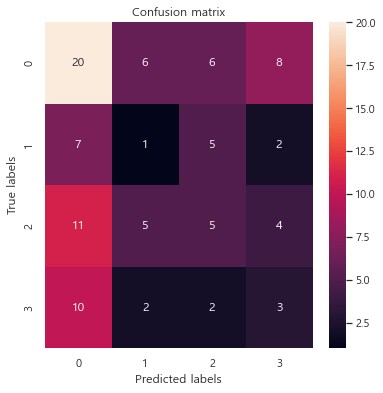

In [55]:
#confusion matrix
from sklearn.metrics import confusion_matrix

# 0. model loading
model = create_model()
model.load_weights(latest)

# 1.Predict classes
test_steps_per_epoch = np.math.ceil(past_test_generator.samples / past_test_generator.batch_size)


predictions = model.predict_generator(past_test_generator, steps=test_steps_per_epoch)
# print(predictions)
# # Get most likely class axis=1(열로 가장 큰 수의 위치를 보겠다는 소리), 
predicted_classes = np.argmax(predictions, axis=1)

# print(predicted_classes)
# # 2.Get ground-truth classes and class-labels
true_classes = past_test_generator.classes
# print(true_classes)
class_labels = list(past_test_generator.class_indices.keys())   
# 3. Use scikit-learn to get statistics
report = classification_report(true_classes, predicted_classes, target_names=class_labels)


print('Confusion Matrix')
print(confusion_matrix(past_test_generator.classes, predicted_classes))
print(report)

plt.figure(figsize=(6,6))
con_test = confusion_matrix(past_test_generator.classes, predicted_classes)
confusion_plot(con_test, 6)